## CSP algorithm for Sudoku puzzles ##

### part a ###

#### Variables ####

Consider each cell in Sudoku puzzle as a variable. There are 81 variables in total. 

Denote each variable as $x_{i,j}$ where $i$ is the row index and $j$ is the column index.

$i \in \{ 0, 1, 2, 3, 4, 5, 6, 7, 8 \}$ and $j \in \{ 0, 1, 2, 3, 4, 5, 6, 7, 8 \}$.

#### Domains ####

For each variable, the domain is $\{ 1, 2, 3, 4, 5, 6, 7, 8, 9 \}$.

#### Constraints ####

Let $0 \leq k \leq 8, k \in \mathbb{Z}.$

$x_{i,j} \neq x_{i,k}$ for any $j \neq k$. (There can't be two same numbers in each row.)

$x_{i,j} \neq x_{k,j}$ for any $i \neq k$. (There can't be two same numbers in each column.)

Let $m, n \in \{ 0, 3, 6 \}$ and $a, b, c, d \in \{ 0, 1, 2 \}$.

$x_{a+m,b+n} \neq x_{c+m,d+n}$ for any $m, n, a, b, c, d$ and $(a+m,b+n) \neq (c+m,d+n)$. (There can't be two same numbers in each subgrid.)

### part b ###

#### Version A : Standard backtracking search (no forward checking, random variable order, random value order)

In [1]:
import numpy as np
import random
import time
import math
import statistics
from tabulate import tabulate

In [2]:
# check if the current selection is valid
def isValid(puzzle, row, col, num):
    # check rows and columns
    for i in range(9):
        if puzzle[row][i] == num or puzzle[i][col] == num:
            return False
            
    # check subgirds
    subRow = 3 * (row // 3)
    subCol = 3 * (col // 3)
    for i in range(subRow, subRow + 3):
        for j in range(subCol, subCol + 3):
            if puzzle[i][j] == num:
                return False
    return True


# return a list of empty variables in the current state of puzzle
def getEmpties(puzzle):
    empties = []
    # iterate to find empty variables
    for row in range(9):
        for col in range(9):
            if puzzle[row][col] == 0:
                empties.append([row,col]) 
    return empties

# record the nodes expanded in backtrack
# need to initialize after each run
countNodesBacktrack = 0

# using recursion in backtracking
def solveBacktrack(puzzle):
    global countNodesBacktrack

    empties = getEmpties(puzzle)

    if (len(empties) == 0): 
        return True

    # store all possible remaining values in a list
    remainingVal = list(range(1, 10))
    
    # choose a random variable
    var = random.choice(empties)
    row = var[0]
    col = var[1]

    while len(remainingVal) != 0:
        # choose a random value
        val = random.choice(remainingVal)
        remainingVal.remove(val)
        countNodesBacktrack += 1
        if isValid(puzzle, row, col, val):
            puzzle[row][col] = val
            solved = solveBacktrack(puzzle)
            if solved:
                return True
            else:
                puzzle[row][col] = 0
    return False
    

#### Version B : Standard backtracking search + forward checking (random variable order, random value order)

In [3]:
# return a 2d list with remaining legal values for unassigned variables
# only run once
def getRVal(puzzle):
    
    # initialize all the 9 possible values for each variable
    remainingVal = []
    for i in range(81):
        sub_list = list(range(1, 10))
        remainingVal.append(sub_list)

    # remove the unavilable values according to initial puzzle
    for row in range(9):
        for col in range(9):
            if puzzle[row][col] != 0:
                # remove values
                remainingVal = removeVal(row, col, puzzle[row][col], remainingVal)
                
    return remainingVal
    

# iterate to remove unlegal values
def removeVal(row, col, value, remainingVal):

    # indicate by zero that the variable is assigned already 
    remainingVal[col + row * 9] = [0]
    
    for i in range(9):
        # filter the row
        tmp = []
        for x in remainingVal[row * 9 + i]:
            if x != value:
                tmp.append(x)
        remainingVal[row * 9 + i] = tmp
        
        # filter the column
        tmp = []
        for x in remainingVal[col + 9 * i]:
            if x != value:
                tmp.append(x)
        remainingVal[col + 9 * i] = tmp

    # filter the subgrid
    subRow = row // 3
    subCol = col // 3
    for i in range(3):
        for j in range(3):
            idx = subCol * 3 + j + (subRow * 3 + i) * 9
            tmp = []
            for x in remainingVal[idx]:
                if x != value:
                    tmp.append(x)
            remainingVal[idx] = tmp
            
    return remainingVal


# check if the value removed is the last available choice
def forwardCheck(remainingVal, value, row, col):
    for i in range(9):
        if i != col:
            if len(remainingVal[row * 9 + i]) == 1 and remainingVal[row * 9 + i][0] == value:
                return False

        if i != row:
            if len(remainingVal[col + 9 * i]) == 1 and remainingVal[col + 9 * i][0] == value:
                return False

    subRow = row // 3
    subCol = col // 3
    for i in range(3):
        for j in range(3):
            if (subRow * 3 + i) != row and (subCol * 3 + j) != col:
                x = remainingVal[subCol * 3 + j + (subRow * 3 + i) * 9]
                if len(x) == 1 and x[0] == value:
                    return False
    return True

# record the nodes expanded in forward checking
# need to initialize after each run
countNodesFC = 0

# using forward checking in backtracking
def solveFC(puzzle):
    global countNodesFC
    
    empties = getEmpties(puzzle)

    if (len(empties) == 0): 
        return True
    
    # choose a random variable
    var = random.choice(empties)
    row = var[0]
    col = var[1]

    remainingVal = getRVal(puzzle)

    rvalues = list(remainingVal[col + row * 9])

    while len(rvalues) != 0:
        # choose a random value
        val = random.choice(rvalues)
        rvalues.remove(val)
        countNodesFC += 1
        if forwardCheck(remainingVal, val, row, col):
            puzzle[row][col] = val
            solved = solveFC(puzzle)
            if solved:
                return True
            else:
                puzzle[row][col] = 0
    return False
    

#### Version C : Standard backtracking search + forward checking + three heuristics to order variables and values (if you need to break ties when selecting variables or values, then do so randomly).

Three heuristics:

- Most Constrained Variable
- Most Constraining Variable
- Least-Constraining Value

In [4]:
# find most contrained variable (least remaining value)
def getMCV(empties, remainingVal):
    # count the constraints for each unassigned variable
    loc = []
    for var in empties:
        index = var[0] * 9 + var[1]
        loc.append(len(remainingVal[index]))
        
    # least remaining value
    lcv = min(loc)

    # maintain the most constrained list
    mcvList = []
    for i in range(len(loc)):
        if loc[i] == lcv:
            mcvList.append(empties[i])
    
    return mcvList


# find the list of constraints in the remaining variables
def getConstrain(row, col, remainingVal):
    subRow = row // 3
    subCol = col // 3

    loc = []
    
    # add all other numbers in the same row
    for r in range(9):
        if r != row:
            index = col + r * 9
            loc.append(remainingVal[index])
    
    # add all other numbers in the same column
    for c in range(9):
        if c != col:
            index = c + row * 9
            loc.append(remainingVal[index])
    
    # add all other numbers in the same subgrid
    for i in range(3):
        for j in range(3):
            newRow = subRow * 3 + i
            newCol = subCol * 3 + j
            if (newRow, newCol) != (row, col):
                index = newCol + newRow * 9
                loc.append(remainingVal[index])
    
    return loc


# find least constraining variable in remaining varaibles
def getLCV(values, row, col, remainingVal):
    lcvList = []
    for value in values:
        count = 0
        locv = getConstrain(row, col, remainingVal)
        for remaining in locv:
            if value in remaining:
                count += 1
        lcvList.append(count)

    # find the min
    lcvIndex = lcvList.index(min(lcvList))
    
    return values[lcvIndex]


# find most contraining variable in list of most constrained variables
# in the use of breaking tie if there are multiple the most constrianed variables
def getMCing(mcvList, puzzle):
    # the list of numbers of constraints
    lon = [numConstraint(var, puzzle) for var in mcvList]
    # maximum number of constraints (the most constraining)
    maxN = max(lon)
    
    mcingvList = []
    for i in range(len(lon)):
        if lon[i] == maxN:
            mcingvList.append(mcvList[i])
    
    return mcingvList


# return the number of constraints based on current cell of puzzle
def numConstraint(var, puzzle):
    row = var[0]
    col = var[1]
    subRow = row // 3
    subCol = col // 3
    
    count = 0
    
    # count unassigned vars in the same row
    for i in range(9):
        if i != col and puzzle[row][i] == 0:
            count += 1
            
    # count unassigned vars in the same column
    for i in range(9):
        if i != row and puzzle[i][col] == 0:
            count += 1
    
    # count unassigned vars in the same subgrid
    for i in range(3):
        for j in range(3):
            newRow = subRow * 3 + i
            newCol = subCol * 3 + j
            if (newRow, newCol) != (row, col) and puzzle[newRow][newCol] == 0:
                count += 1
                
    return count

# record the nodes expanded in using Heuristics
# need to initialize after each run
countNodesHeu = 0

# use backtracking, forward checking and three heuristics
def solveHeu(puzzle):
    global countNodesHeu
    
    empties = getEmpties(puzzle)

    if (len(empties) == 0): 
        return True
    
    remainingVal = getRVal(puzzle)

    # find the most constrained variable
    mcvList = getMCV(empties, remainingVal)
    
    # only one most contrained variable is returned
    if len(mcvList) == 1:
        var = mcvList[0]
    else:
        # if there is a tie, choose the most constraining variable to break tie
        # piazza @33
        # var = random.choice(mcvList)
        mcingvList = getMCing(mcvList, puzzle)
        var = mcingvList[0]
    
    row = var[0]
    col = var[1]
    rvalues = list(remainingVal[col + row * 9])
    
    while len(rvalues) != 0:
        # choose the least constraining value
        val = getLCV(rvalues, row, col, remainingVal)
        rvalues.remove(val)
        countNodesHeu += 1
        if forwardCheck(remainingVal, val, row, col):
            puzzle[row][col] = val
            solved = solveHeu(puzzle)
            if solved:
                return True
            else:
                puzzle[row][col] = 0
    return False
    

### part c ###

In [5]:
# test cases:
easy_test = [
    [0, 1, 0, 9, 0, 0, 0, 5, 3],
    [0, 4, 0, 3, 0, 0, 6, 8, 1],
    [0, 7, 0, 0, 5, 0, 9, 0, 0],
    [5, 9, 0, 0, 7, 0, 0, 4, 0],
    [7, 0, 0, 8, 0, 5, 0, 0, 9],
    [0, 2, 0, 0, 3, 0, 0, 6, 7],
    [0, 0, 9, 0, 1, 0, 0, 7, 0],
    [1, 5, 7, 0, 0, 3, 0, 9, 0],
    [4, 8, 0, 0, 0, 2, 0, 3, 0]]

medium_test = [
    [0, 0, 0, 1, 6, 0, 9, 2, 5],
    [0, 0, 7, 0, 0, 0, 1, 8, 0],
    [0, 0, 0, 0, 8, 0, 0, 0, 6],
    [7, 8, 0, 2, 0, 0, 0, 0, 0],
    [0, 2, 5, 0, 1, 0, 6, 3, 0],
    [0, 0, 0, 0, 0, 8, 0, 1, 7],
    [1, 0, 0, 0, 7, 0, 0, 0, 0],
    [0, 6, 2, 0, 0, 0, 7, 0, 0],
    [8, 7, 4, 0, 2, 3, 0, 0, 0]]

hard_test = [
    [1, 0, 3, 0, 0, 5, 4, 0, 0],
    [8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 6, 0, 0],
    [0, 0, 6, 0, 4, 9, 0, 0, 0],
    [0, 7, 9, 6, 0, 8, 2, 4, 0],
    [0, 0, 0, 2, 1, 0, 9, 0, 0],
    [0, 0, 5, 0, 7, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 6],
    [0, 0, 7, 5, 0, 0, 1, 0, 3]]

evil_test = [
    [0, 0, 1, 9, 7, 0, 0, 0, 0],
    [0, 9, 0, 0, 0, 3, 0, 0, 8],
    [0, 0, 0, 4, 0, 2, 0, 0, 0],
    [6, 1, 0, 0, 0, 0, 4, 0, 5],
    [0, 0, 3, 0, 0, 0, 1, 0, 0],
    [4, 0, 7, 0, 0, 0, 0, 2, 9],
    [0, 0, 0, 7, 0, 5, 0, 0, 0],
    [2, 0, 0, 3, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 8, 9, 5, 0, 0]]

In [6]:
# test solutions
easy_soln = [
    [6, 1, 2, 9, 8, 4, 7, 5, 3],
    [9, 4, 5, 3, 2, 7, 6, 8, 1],
    [3, 7, 8, 6, 5, 1, 9, 2, 4],
    [5, 9, 1, 2, 7, 6, 3, 4, 8],
    [7, 6, 3, 8, 4, 5, 2, 1, 9],
    [8, 2, 4, 1, 3, 9, 5, 6, 7],
    [2, 3, 9, 5, 1, 8, 4, 7, 6],
    [1, 5, 7, 4, 6, 3, 8, 9, 2],
    [4, 8, 6, 7, 9, 2, 1, 3, 5]]

medium_soln = [
    [3, 4, 8, 1, 6, 7, 9, 2, 5],
    [6, 5, 7, 3, 9, 2, 1, 8, 4],
    [2, 1, 9, 5, 8, 4, 3, 7, 6],
    [7, 8, 1, 2, 3, 6, 4, 5, 9],
    [4, 2, 5, 7, 1, 9, 6, 3, 8],
    [9, 3, 6, 4, 5, 8, 2, 1, 7],
    [1, 9, 3, 6, 7, 5, 8, 4, 2],
    [5, 6, 2, 8, 4, 1, 7, 9, 3],
    [8, 7, 4, 9, 2, 3, 5, 6, 1]]

hard_soln = [
    [1, 6, 3, 9, 2, 5, 4, 7, 8],
    [8, 9, 4, 3, 6, 7, 5, 1, 2],
    [7, 5, 2, 4, 8, 1, 6, 3, 9],
    [2, 1, 6, 7, 4, 9, 3, 8, 5],
    [3, 7, 9, 6, 5, 8, 2, 4, 1],
    [5, 4, 8, 2, 1, 3, 9, 6, 7],
    [6, 3, 5, 1, 7, 2, 8, 9, 4],
    [9, 2, 1, 8, 3, 4, 7, 5, 6],
    [4, 8, 7, 5, 9, 6, 1, 2, 3]]

evil_soln = [
    [3, 4, 1, 9, 7, 8, 6, 5, 2],
    [5, 9, 2, 1, 6, 3, 7, 4, 8],
    [7, 6, 8, 4, 5, 2, 3, 9, 1],
    [6, 1, 9, 8, 2, 7, 4, 3, 5],
    [8, 2, 3, 5, 9, 4, 1, 7, 6],
    [4, 5, 7, 6, 3, 1, 8, 2, 9],
    [9, 3, 6, 7, 1, 5, 2, 8, 4],
    [2, 8, 5, 3, 4, 6, 9, 1, 7],
    [1, 7, 4, 2, 8, 9, 5, 6, 3]]

In [7]:
# versions: ['A', 'B', 'C']
# test_cases: [easy_test, medium_test, hard_test, evil_test]
import copy

def runTest(version, puzzle, puzzle_name, trial):
    global countNodesBacktrack
    global countNodesFC
    global countNodesHeu
    times = []
    nodesExpanded = []
    for i in range(trial):
        # initialize the puzzle everytime
        tmp = copy.deepcopy(puzzle)
        start = time.time()
        if version == 'A':
            solveBacktrack(tmp)
            nodes = countNodesBacktrack
        if version == 'B':
            solveFC(tmp)
            nodes = countNodesFC
        if version == 'C':
            solveHeu(tmp)
            nodes = countNodesHeu
                
        end = time.time()
        times.append(end - start)
        nodesExpanded.append(nodes)
        countNodesBacktrack = 0
        countNodesFC = 0
        countNodesHeu = 0
        
    return ([version,
             puzzle_name,
             round(statistics.mean(times), 6), 
             round(statistics.stdev(times), 6)],
            [version,
             puzzle_name,
             round(statistics.mean(nodesExpanded), 6),
             round(statistics.stdev(nodesExpanded), 6)])


In [8]:
# skip evil_test and hard_test for version A
# reduce number of runs to 30 to make it feasible
laEasy = runTest('A', easy_test, "easy_test", 30)
# reduce number of runs to 3 to make it feasible
laMedium = runTest('A', medium_test, "medium_test", 3)

In [17]:
lbEasy = runTest('B', easy_test, "easy_test", 50)

In [19]:
# reduce number of runs to 15 to make it feasible
lbMedium = runTest('B', medium_test, "medium_test", 15)

In [23]:
# reduce number of runs to 2 to make it feasible
lbHard = runTest('B', hard_test, "hard_test", 2)
# reduce number of runs to 2 to make it feasible
lbEvil = runTest('B', evil_test, "evil_test", 2)

In [24]:
lcEasy = runTest('C', easy_test, "easy_test", 50)
lcMedium = runTest('C', medium_test, "medium_test", 50)
lcHard = runTest('C', hard_test, "hard_test", 50)
lcEvil = runTest('C', evil_test, "evil_test", 50)

In [25]:
timeTable = [['Version', 'Puzzle', 'Average Time', 'Standard Deviation'], 
             laEasy[0], laMedium[0], 
             lbEasy[0], lbMedium[0], lbHard[0], lbEvil[0],
             lcEasy[0], lcMedium[0], lcHard[0], lcEvil[0]]

nodeTable = [['Version', 'Puzzle', 'Average Node', 'Standard Deviation'], 
             laEasy[1], laMedium[1], 
             lbEasy[1], lbMedium[1], lbHard[1], lbEvil[1],
             lcEasy[1], lcMedium[1], lcHard[1], lcEvil[1]]

print(tabulate(timeTable, headers='firstrow', tablefmt='grid'))
print(tabulate(nodeTable, headers='firstrow', tablefmt='grid'))

+-----------+-------------+----------------+----------------------+
| Version   | Puzzle      |   Average Time |   Standard Deviation |
+===========+=============+================+======================+
| A         | easy_test   |       3.01488  |             1.62583  |
+-----------+-------------+----------------+----------------------+
| A         | medium_test |     125.053    |            56.5564   |
+-----------+-------------+----------------+----------------------+
| B         | easy_test   |       0.148191 |             0.092835 |
+-----------+-------------+----------------+----------------------+
| B         | medium_test |       6.51837  |             4.02215  |
+-----------+-------------+----------------+----------------------+
| B         | hard_test   |     112.899    |            15.468    |
+-----------+-------------+----------------+----------------------+
| B         | evil_test   |      94.8172   |             9.62837  |
+-----------+-------------+----------------+----

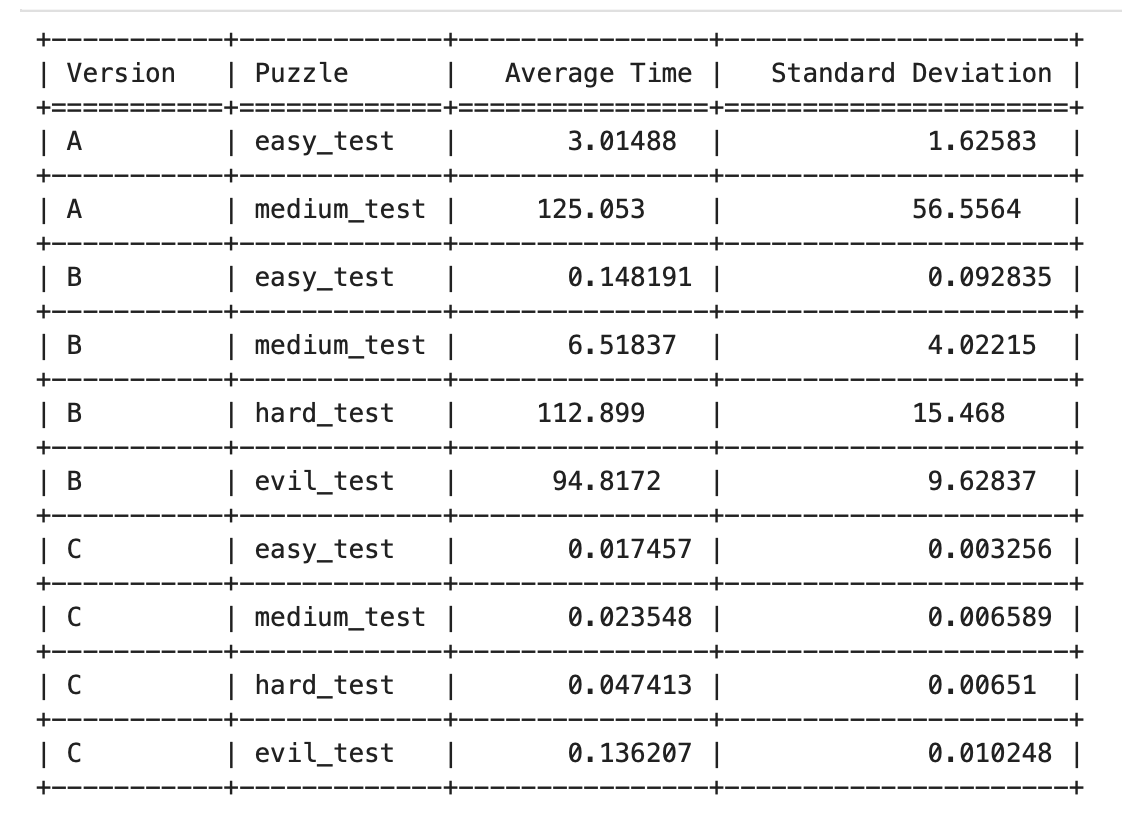

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread('time_table.png')

# Create a new figure
plt.figure(figsize=(img.shape[1]/100, img.shape[0]/100), dpi=100)

# Display the image without axes
plt.imshow(img)
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()


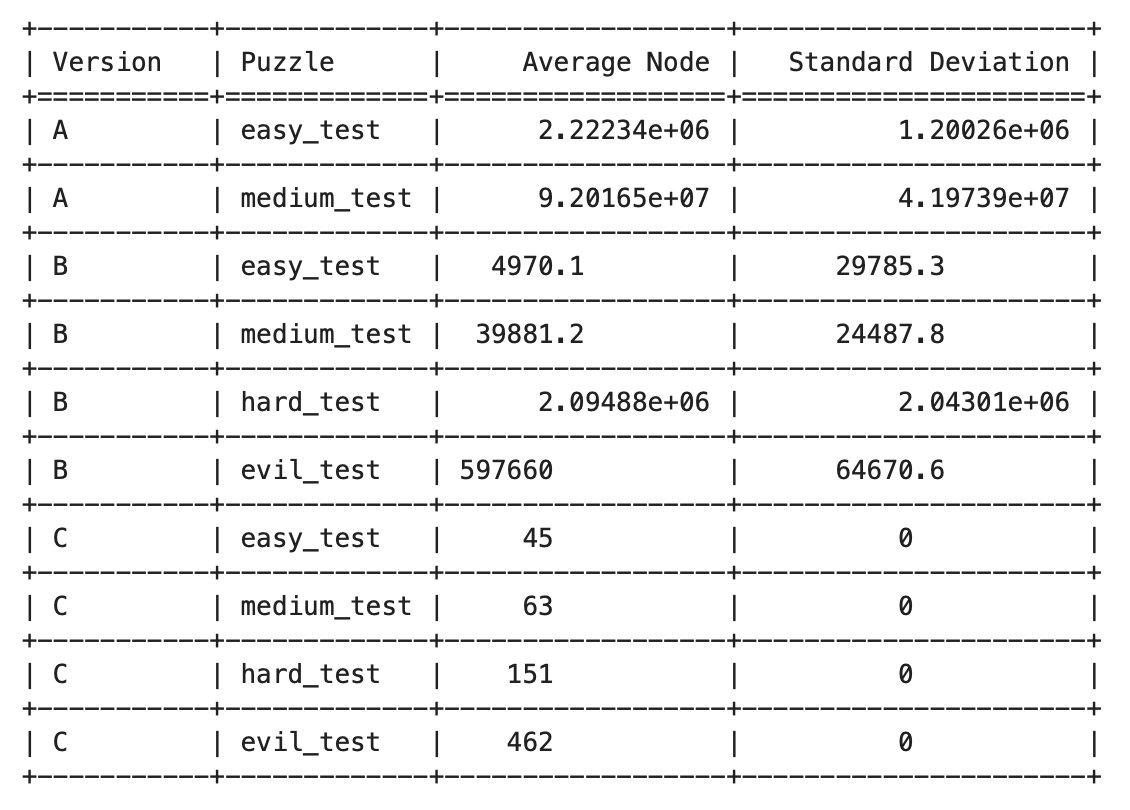

In [27]:
# Load the image
img = mpimg.imread('node_table.png')

# Create a new figure
plt.figure(figsize=(img.shape[1]/100, img.shape[0]/100), dpi=100)

# Display the image without axes
plt.imshow(img)
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()


##### Above are the two examples of time table and node table, which can be found in the Q4 folder. 
##### Another example of time table can be found as 'time_table2.png'.

#### Discussion

If only the standard backtracking method is used, the program is guaranteed to find a solution as long as there is one, since the program ends up trying every possible number at every possible location. Therefore, time consuming and nodes explored in this case is huge.

Forward checking improves efficiency by dynamically eliminating infeasible and illegal paths based on the current node to be explored. This reduces the number of nodes to be explored and the time spent.

Both of the above versions randomly select the next node to be expanded, resulting in search trees with very different depths and number of branches. As a result, the standard deviation is large in these cases.

Utilizing two heuristic functions (most constrained variable and most constraining variable), the program cleverly selects the most promising node to assign the next value to, effectively reducing uncertainty and attempts at each step. In addition, using the heuristic function (least constraining value), the selected value has less impact on its "neighboring" variables. This reduces conflicts and provides greater flexibility for subsequent value assignments. In addition, the order in which variables and values are explored depends mainly on the current node, and randomness has little effect on the search tree. As a result, it has a very small standard deviation.

The difficulty of the puzzle also directly affects the efficiency of the solution algorithm. Harder problems will start with more unassigned variables, leaving more blanks and explorations for the algorithm and thus consuming more time.